# Evaluate the Relative Risk of Covid-19 death in states with no mask mandate vs. states with mask mandates over time

## BLUF (bottom line up front): 
## In October, residents in states without mask mandates were about 70% more likely to die of Covid-19 than residents of states with mask mandates.




### This analysis utilizes data from the Johns Hopkins University Github and an epidemiological concept known as Relative Risk Ratios to extimate the comparative probabilities of Covid-19 deaths between the two groups.
### JHU data: https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv
### AARP Mask Mandate data: https://www.aarp.org/health/healthy-living/info-2020/states-mask-mandates-coronavirus.html 
### County population 2019 data: https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-total.html![image.png](attachment:image.png)

### CDC Relative Risk Ratio calculation methodology: Principles of Epidemiology in Public Health Practice, Third Edition An Introduction to Applied Epidemiology and Biostatistics (https://www.cdc.gov/csels/dsepd/ss1978/lesson3/section5.html)

### Author: Alex Rich, MPH https://www.linkedin.com/in/alex-rich-940651a8/
### alex.rich@unc.edu

### I'm a former Air Force special operations pilot and crash investigator with a Masters in Public Health from Yale university.  I'm currently completing a PhD in health informatics at UNC Chapel Hill.  I look at public health crises with the tools of aviation safety, focusing on data analysis and visual communication.

In [17]:
import os
import wget
import pandas as pd
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
# Python version 3.7.3
## Package Versions:
# wget==3.2
# pandas==1.1.1
#

In [2]:
# Check package versions:
# import pkg_resources
# pkg_resources.get_distribution('pandas').version

## Update file of covid deaths from JHU Github

In [3]:
fpData = os.getcwd()+'/data/'
## Get daily update of hopkins time series file for confirmed US cases
wget.download('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv',\
              out = fpData +'covid_hopkins_overTime_DEATHS.csv')
## if file saves as a ____(01).csv, delete the old file and rename new to "covid_hopkins_overTime_CONFIRMED.csv"
if os.path.exists(fpData + "covid_hopkins_overTime_DEATHS (1).csv"):
    os.remove(fpData + "covid_hopkins_overTime_DEATHS.csv")
    os.rename(fpData + "covid_hopkins_overTime_DEATHS (1).csv",fpData + "covid_hopkins_overTime_DEATHS.csv")
    

In [4]:
# Read in new US Confirmed Timeseries data

covidDeaths = pd.read_csv(fpData +'covid_hopkins_overTime_DEATHS.csv',dtype={'FIPS':str})
covidDeaths.FIPS = covidDeaths.FIPS.str.split('.').str[0].str.zfill(5)

# collect dates from timeseries file
dates = []
for i in covidDeaths.columns:
    if '/' in i:
        dates.append(i)
        
fipsList = covidDeaths[~covidDeaths.FIPS.isnull()].FIPS.unique().tolist()



## Load county population estimates for 2019 from US census file

In [5]:
countyPops = pd.read_csv('/Users/alex/Documents/Compare Hopkins and NYT/co-est2019-alldata.csv',encoding='Latin1',\
                        dtype={'STATE':str,'COUNTY':str})
countyPops['fips'] = countyPops.STATE + countyPops.COUNTY

In [6]:
covidDeaths = pd.merge(covidDeaths,countyPops[['fips','POPESTIMATE2019']],left_on='FIPS',right_on='fips',how='left')

In [7]:
covidDeaths['state'] = covidDeaths.Province_State.str.lower()

## Load .csv of mask mandate data derrived from AARP website

In [8]:
# States with No Mask Mandates as of the end of October
# Read in .csv file derrived from https://www.aarp.org/health/healthy-living/info-2020/states-mask-mandates-coronavirus.html accessed on 2 nov
stateMasks = pd.read_csv(os.getcwd()+'/data/stateMaskRegs.csv')
stateMasks.dateOfReg = pd.to_datetime(stateMasks.dateOfReg)
noMasks = stateMasks[stateMasks.maskReg=='no'].state.tolist()

In [9]:
# define function for getting last day of month
# credit: augustomen on stackoverflow https://stackoverflow.com/questions/42950/how-to-get-the-last-day-of-the-month
def last_day_of_month(any_day):
    # this will never fail
    # get close to the end of the month for any day, and add 4 days 'over'
    next_month = any_day.replace(day=28) + dt.timedelta(days=4)
    # subtract the number of remaining 'overage' days to get last day of current month, or said programattically said, the previous day of the first of next month
    return next_month - dt.timedelta(days=next_month.day)

In [10]:
# Function for creating dataframe of monthly relative risk ratios for covid death, no-mask-mandate states vs. all others
def stateDeathRR(noMasks):
    rrList = []
    # Iterate through each month (march through october)
    for month in range(3, 11):
        endDate = last_day_of_month(dt.date(2020, (month), 1))
        endOfMonth = endDate.strftime('%-m/%-d/%y')
        lastMonth = last_day_of_month(dt.date(2020, (month-1), 1)).strftime('%-m/%-d/%y')

    #     noMasks = stateMasks[stateMasks.dateOfReg > endOfMonth].state.unique().tolist()
        exposedCases= covidDeaths[covidDeaths.state.isin(noMasks)][endOfMonth].sum() - covidDeaths[covidDeaths.state.isin(noMasks)][lastMonth].sum()

        exposedNotCases = covidDeaths[covidDeaths.state.isin(noMasks)].POPESTIMATE2019.sum() - covidDeaths[covidDeaths.state.isin(noMasks)][endOfMonth].sum()

        notExposedCases = covidDeaths[((~covidDeaths.state.isin(noMasks)))][endOfMonth].sum() - covidDeaths[(~covidDeaths.state.isin(noMasks))][lastMonth].sum()

        notExposedNotCases = covidDeaths[~covidDeaths.state.isin(noMasks)].POPESTIMATE2019.sum() - covidDeaths[~covidDeaths.state.isin(noMasks)][endOfMonth].sum()

        try:
            rr = (exposedCases / (exposedCases + exposedNotCases)) / (notExposedCases /(notExposedCases + notExposedNotCases))

        except:
            rr=0

        entry = {
            'month':month,
            'endDay':endDate,#dt.datetime(2020,month,1,0,0),
            'noMaskStates':noMasks,
            'noMaskCount':len(noMasks),
            'a': exposedCases, # covid deaths in no-mask states in October
            'b':exposedNotCases, # living population in no-mask states as of 1 october who didn't die of Covid by 31 Oct
            'c':notExposedCases, # covid deaths in mask-mandate states in October
            'd':notExposedNotCases, # living popualtion in mask-mandate states as of 1 October who didn't die of Covid by 31 Oct
            "relative risk vs. nation":round(rr,2),
        }
        rrList.append(entry)
    # print most recent risk ratio for covid deaths, no-mask-mandate states vs. mask-mandate states
    print(round(rr,2))
    return(rrList)

In [11]:
deathRisk = pd.DataFrame(stateDeathRR(noMasks))

1.69


In [12]:
deathRisk

,month,endDay,noMaskStates,noMaskCount,a,b,c,d,relative risk vs. nation
0,3,2020-03-31,"[alaska, arizona, florida, georgia, idaho, iow...",17,361,78821189.0,4890,249413082.0,0.23
1,4,2020-04-30,"[alaska, arizona, florida, georgia, idaho, iow...",17,4190,78816999.0,56488,249356594.0,0.23
2,5,2020-05-31,"[alaska, arizona, florida, georgia, idaho, iow...",17,4894,78812105.0,36790,249319804.0,0.42
3,6,2020-06-30,"[alaska, arizona, florida, georgia, idaho, iow...",17,4161,78807944.0,15978,249303826.0,0.82
4,7,2020-07-31,"[alaska, arizona, florida, georgia, idaho, iow...",17,9317,78798627.0,16977,249286849.0,1.74
5,8,2020-08-31,"[alaska, arizona, florida, georgia, idaho, iow...",17,11321,78787306.0,18248,249268601.0,1.96
6,9,2020-09-30,"[alaska, arizona, florida, georgia, idaho, iow...",17,8423,78778883.0,15067,249253534.0,1.77
7,10,2020-10-31,"[alaska, arizona, florida, georgia, idaho, iow...",17,8250,78770633.0,15461,249238073.0,1.69


In [13]:
# Make .csv to check math for Risk Ratio cacluations
covidDeaths[covidDeaths.state.isin(noMasks)][['Admin2','state','9/30/20','10/31/20','POPESTIMATE2019']].to_csv(os.getcwd()+'/no_mask_states_OctoberCovidDeaths.csv',index=False)


In [14]:
# Make .csv to check math for Risk Ratio cacluations

covidDeaths[(~covidDeaths.state.isin(noMasks))&(~covidDeaths.Province_State.isnull())][['Admin2','state','9/30/20','10/31/20','POPESTIMATE2019']].to_csv(os.getcwd()+'/MASK_states_OctoberCovidDeaths.csv',index=False)


In [15]:
# Calcualtions to check .csv against
deathRisk[deathRisk.month==10]

,month,endDay,noMaskStates,noMaskCount,a,b,c,d,relative risk vs. nation
7,10,2020-10-31,"[alaska, arizona, florida, georgia, idaho, iow...",17,8250,78770633.0,15461,249238073.0,1.69


# Plot the results

0.6
1.69


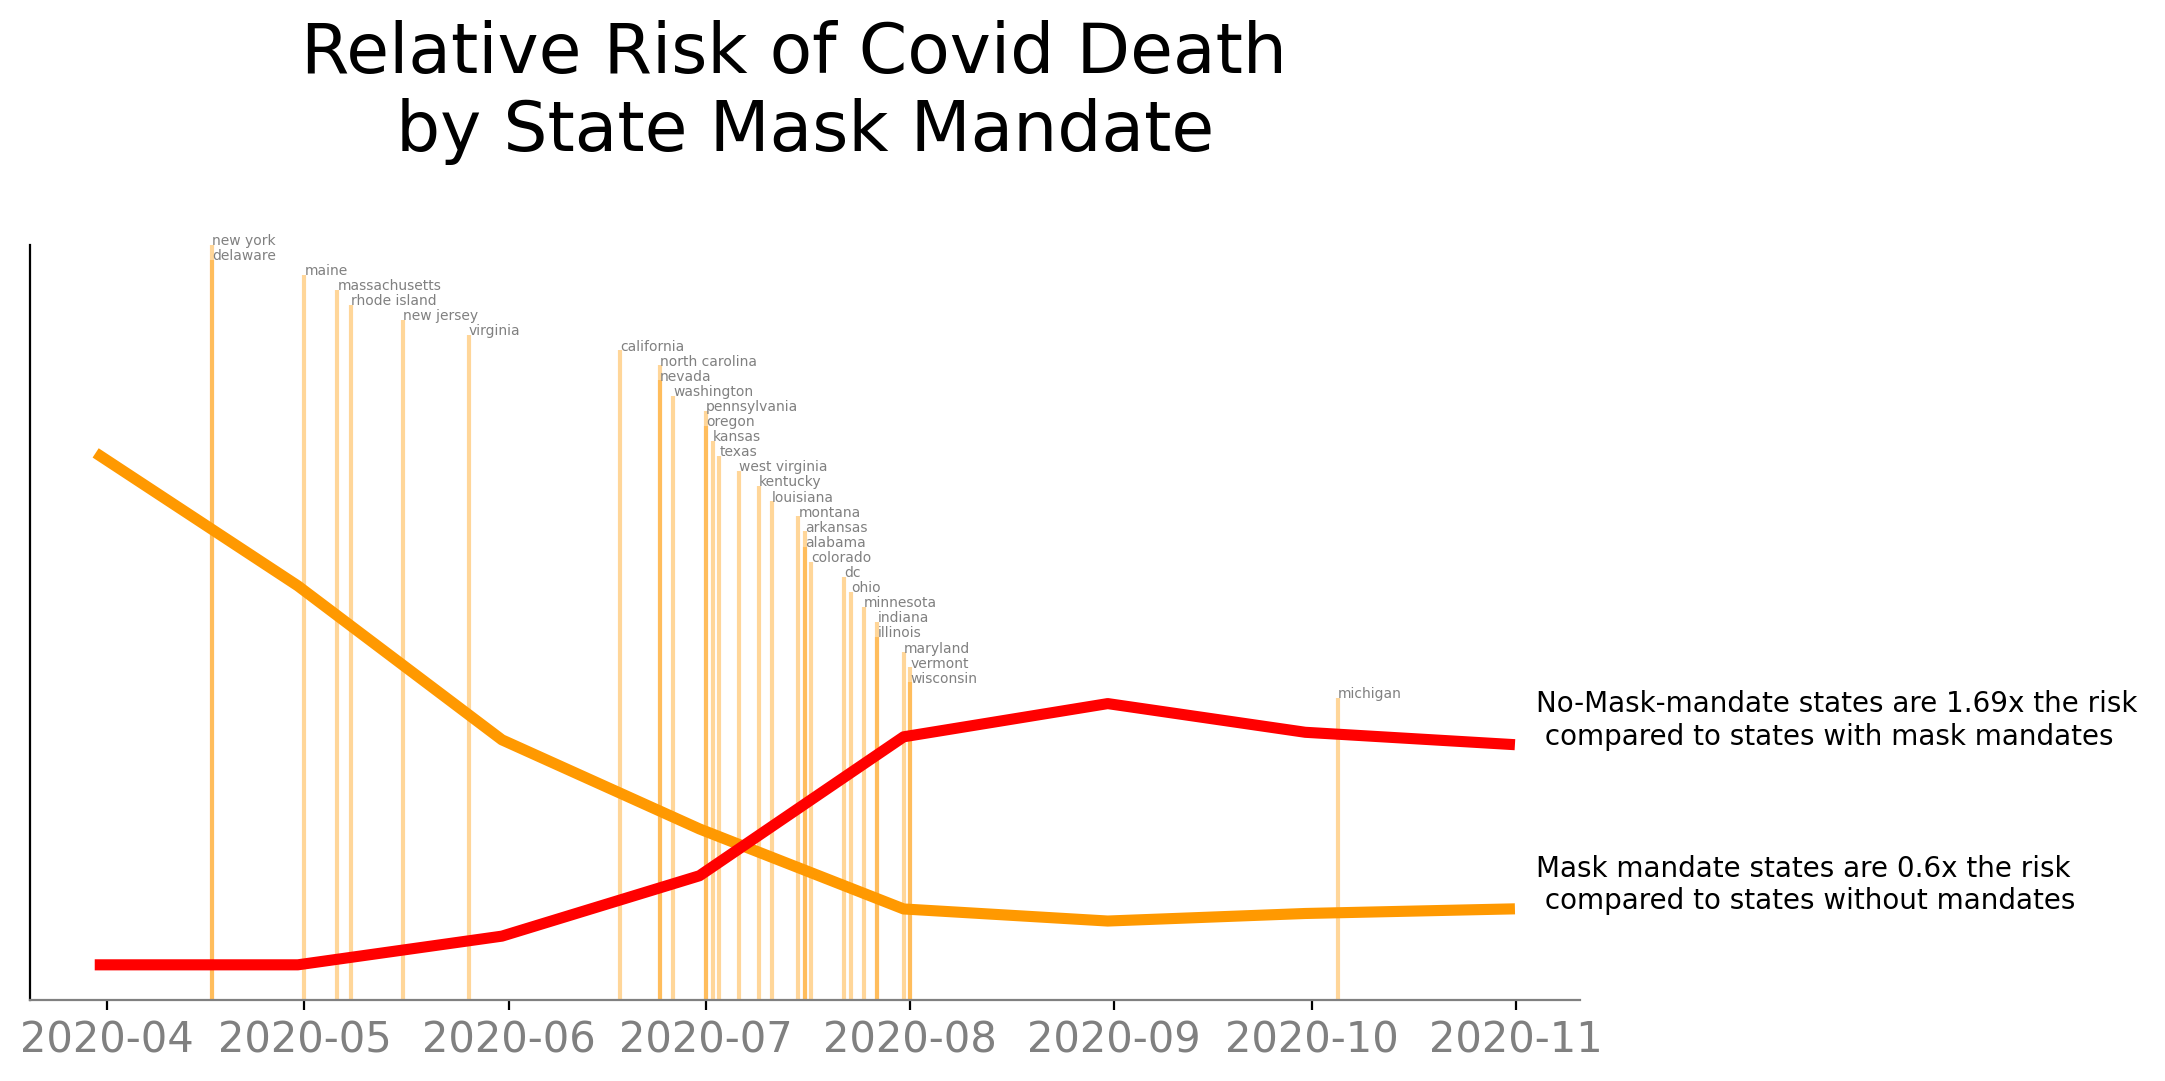

In [19]:
##
# Plot
##
state = stateMasks[~stateMasks.state.isin(noMasks)].state.unique().tolist()
deathRR = pd.DataFrame(stateDeathRR(state))

countyColor = '#FF9901'


plt.figure(figsize=(10,5),dpi=200)
ax = plt.subplot(111)


deathRR.set_index('endDay')['relative risk vs. nation'].plot.line(linewidth=4,color=countyColor)

counter = 0
stateMasks = stateMasks.sort_values('dateOfReg',ascending=True)
for s in state:
    if stateMasks[stateMasks.state==s].dateOfReg.item() < dt.datetime(2020,12,1,0,0):
        plt.vlines(x = stateMasks[stateMasks.state==s].dateOfReg.item(),ymax =(5-counter*.1),ymin=0, color= countyColor, linestyle='-',alpha=0.4)
        plt.text(stateMasks[stateMasks.state==s].dateOfReg.item(),(5-counter*.1),s,fontsize=5,color='grey')
        counter = counter + 1

plt.title("Relative Risk of Covid Death \n by State Mask Mandate \n",fontsize=25)
# plt.title("Relative Risk of Covid Death," + state + " vs. Others",fontsize=20)
plt.xlabel('')


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
plt.yticks([])

# ax.spines['left'].set_color('darkgrey')
ax.spines['bottom'].set_color('grey')

# percInfectedList = weekly.perHundK.tolist()




# ax.tick_params(axis="y", labelsize=15,color='grey')
ax.tick_params(axis="x", labelsize=15,labelcolor='grey')

plt.minorticks_off()





state = noMasks

endRR = deathRR[deathRR.endDay == deathRR.endDay.max()]['relative risk vs. nation'].item()
labelText = "Mask mandate states are " + str(endRR) +"x the risk \n compared to states without mandates"
plt.text(dt.date(2020, 11, 4),deathRR[deathRR.endDay == deathRR.endDay.max()]['relative risk vs. nation'].item(),labelText,horizontalalignment='left',fontsize=10)


state = stateMasks[stateMasks.state.isin(noMasks)].state.unique().tolist()
deathRR = pd.DataFrame(stateDeathRR(state))
deathRR.set_index('endDay')['relative risk vs. nation'].plot.line(linewidth=4,color='red')



endRR = deathRR[deathRR.endDay == deathRR.endDay.max()]['relative risk vs. nation'].item()
labelText = "No-Mask-mandate states are " + str(endRR) +"x the risk \n compared to states with mask mandates"
plt.text(dt.date(2020, 11, 4),deathRR[deathRR.endDay == deathRR.endDay.max()]['relative risk vs. nation'].item(),labelText,horizontalalignment='left',fontsize=10)



# lastDayDeaths = '{:,}'.format(int(weekly[-1:].weeklyDeaths.item()))

# deathsLabelText = lastDayDeaths + " deaths in the last 7 days"
# # labelTwoText =  str(daily[-1:].percInfected.item()) + ' % of Population'

# plt.text(max(weekly.dt+dt.timedelta(days=4)),weekly.weeklyDeaths[-1:].item(),deathsLabelText,horizontalalignment='left',fontsize=30)



# plt.text(max(daily.dt+dt.timedelta(days=5)),daily.perHundK[-1:].item()-15,"on {} within an hour's drive".format(dt.datetime.strptime(dates[-1],"%m/%d/%y").strftime("%d %b")),horizontalalignment='left',color='grey',fontsize=20)


# plt.tight_layout()




import math
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10


# plt.yticks(np.arange(0,roundup(weekly.weeklyNew.max())+10, roundup(weekly.weeklyNew.max())),fontsize=20,color='grey')


# if daily.perHundK.max() > 120:
#     plt.ylim(0,daily.perHundK.max()+10)
#     plt.yticks(np.arange(0,roundup(daily.perHundK.max())+10, roundup(daily.perHundK.max())))

# else:
#     plt.ylim(0,120)
#     plt.yticks(np.arange(0,130, 120))


plt.ylim(0,5)


plt.xlabel('')

# plt.yticks(np.arange(0,200, 190))
# plt.ylim(0,140)
# plt.yticks(np.arange(0,140, 130))

# fp = os.getcwd() + '/plots/'+location + '.png'
# plt.savefig(fp,bbox_inches="tight")
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))


plt.show()

